In [0]:
import pandas as pd  # data frame operations
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
import math

from pandas import Series
from statistics import mean
from statistics import median


from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


Import data

In [3]:
homes = pd.read_csv('https://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv', encoding='latin_1')
homes

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1486790.0,1490909.0,1493113.0,1500163.0,1497306.0,1496223.0,1498588.0,1504899.0,1511536.0,1509462.0,1518963.0,1518670.0,1526823.0,1512395.0,1503332,1483368,1468482,1461572,1454050,1454111,1451781,1449835,1450723,1440314,1433973,1429073,1428637,1425987,1407384,1391270,1380332,1386270,1394397,1404225,1406599,1399918,1380178,1358401,1350481,1345845
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,355664.0,354736.0,355404.0,355863.0,357309.0,359906.0,362935.0,366493.0,369236.0,371964.0,374364.0,376322.0,377455.0,380637.0,381917.0,384322.0,383195.0,381889.0,378162.0,374642.0,373445.0,370798.0,369891.0,367735.0,369673.0,371771.0,378334.0,386284.0,395034.0,403790.0,412949.0,421560.0,428867.0,...,926166.0,926066.0,929987.0,931155.0,933542.0,935872.0,945765.0,950893.0,950923.0,945971.0,940106.0,937789.0,937761.0,935120.0,931248,932154,941705,953981,959260,960954,959673,959082,954912,950660,948543,948906,951721,954743,957441,961651,966123,967557,965155,960225,956709,953095,950684,948136,946838,945928
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1627167.0,1630578.0,1630922.0,1629389.0,1620963.0,1608791.0,1600559.0,1600247.0,1598869.0,1595751.0,1595421.0,1597321.0,1600114.0,1584614.0,1566777,1543592,1531018,1537936,1551681,1568820,1573613,1578249,1582848,1583553,1580068,1573052,1563902,1550264,1531141,1521399,1520816,1526676,1525174,1516721,1504180,1492086,1480934,1468075,1454870,1438313
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,197907.0,196854.0,195911.0,197300.0,197320.0,198443.0,197736.0,198462.0,199158.0,200824.0,201754.0,202558.0,205017.0,207485.0,208972.0,209013.0,211437.0,215407.0,217938.0,217189.0,214825.0,211272.0,209083.0,206815.0,206114.0,205047.0,204507.0,204444.0,203423.0,203923.0,204949.0,207069.0,207697.0,...,329476.0,328831.0,328912.0,329142.0,329312.0,330345.0,331281.0,331534.0,330699.0,330184.0,330013.0,329488.0,329015.0,328902.0,329123,330287,331699,332214,332264,332737,333805,334293,333806,333609,333839,334129,334753,334497,335272,335363,335789,335035,334542,334176,334363,334127,334458,334460,334679,334309
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,537402.0,536919.0,539044.0,540137.0,542594.0,546190.0,550015.0,554436.0,557214.0,560140.0,562389.0,565003.0,566844.0,574208.0,578552.0,583864.0,582314.0,581470.0,578402.0,575431.0,574291.0,575269.0,578602.0,583276.0,588869.0,596347.0,604371.0,615222.0,625944.0,640232.0,651765.0,662952.0,671169.0,...,1141840.0,1140892.0,1144867.0,1147812.0,1153703.0,1159757.0,1174693.0,1185995.0,1191061.0,1187382.0,1179120.0,1174446.0,1174467.0,1173676.0,1172203,1176623,1186741,1197817,1201566,1204015,1204371,1201598,1195307,1189358,1186838,1185950,1187917,1190385,1191138,1193324,1198898,1203423,1204840,1199747,1194591,1188702,1183500,1179024,1175407,1174008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

Arkansas Metro area analysis

In [0]:
ar_homes = homes[homes.State=='AR']

df = pd.DataFrame()
def getMetroAvg(cityName, col):
  global df
  city_homes = ar_homes.loc[ar_homes.City==cityName, col]
  avg = mean(city_homes[~np.isnan( city_homes)])
  df = df.append({'Date':date, 'Avg':avg, 'City':cityName}, ignore_index=True )

for col in ar_homes.columns: 
    date = pd.to_datetime(col, format='%Y-%m', errors='coerce')
    if(date >= pd.to_datetime('01-01-2017')):
      # get metro averages
      getMetroAvg('Hot Springs', col)  
      getMetroAvg('Little Rock', col)  
      getMetroAvg('Fayetteville', col)  
      getMetroAvg('Searcy', col)  

df = df.set_index('Date')
#df.iloc[0]

# Plot
groups = df.groupby(pd.Grouper('City'))
groups.plot(subplots=True, figsize=(6, 2)); 

In [0]:
Forecasting avg median housing value by zip code in 2018

In [0]:
# Make series

df = pd.DataFrame()
regions = ar_homes.RegionID.unique()

def saveMonthRow(colIndex):
  # save 1 row in df, with a column for each region with a value of the median price
  global df
  date = pd.to_datetime(ar_homes.columns[c], format='%Y-%m', errors='coerce')
  row = {'Date':date}
  for r in range(0, len(regions)-1):
    region_homes_in_month = ar_homes.loc[ar_homes.RegionID==regions[r], ar_homes.columns[c]]
    region_homes_in_month = region_homes_in_month[~np.isnan(region_homes_in_month)]
    if len(region_homes_in_month) > 0:
      mid = median(region_homes_in_month)
    row.update( {regions[r]:mid} )

  df = df.append(row, ignore_index=True )


# for each month column...
for c in range(7,len(ar_homes.columns)-1):
  saveMonthRow(c)

df = df.set_index('Date')



In [39]:
df

,58069,58129,59770,89131,89132,89133,89137,89138,89139,89140,89141,89142,89143,89144,89145,89146,89147,89148,89149,89150,89151,89152,89155,89157,89160,89161,89162,89163,89164,89165,89166,89167,89168,89169,89171,89173,89175,89176,89177,89178,...,89786,89787,89788,89790,89791,89792,89796,89798,89799,89802,89805,89809,89810,89811,89812,89813,89814,89815,89816,89817,89818,89819,89820,89821,89822,89823,89824,89825,89827,89828,89829,89830,89831,89832,89833,89834,89835,89837,89838,399617
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-04-01,71416.0,102662.0,43168.0,18884.0,51734.0,42400.0,19632.0,17346.0,40082.0,147480.0,30113.0,55269.0,52231.0,42527.0,17346.0,50273.0,44260.0,11468.0,16902.0,107532.0,29978.0,58279.0,41805.0,53003.0,50574.0,78024.0,44496.0,43127.0,33627.0,56637.0,37484.0,43646.0,55130.0,44496.0,73102.0,53063.0,44496.0,52877.0,96750.0,27288.0,...,21280.0,36462.0,65357.0,42517.0,39822.0,55269.0,43933.0,86341.0,36449.0,86860.0,107914.0,71812.0,64729.0,41805.0,56637.0,17346.0,60783.0,53810.0,49152.0,57581.0,33837.0,69214.0,66614.0,95324.0,46260.0,65162.0,53063.0,39620.0,37086.0,41138.0,19632.0,75007.0,52877.0,16902.0,53063.0,26052.0,66777.0,43127.0,83023.0,98615.0
1996-05-01,71427.0,103027.0,43089.0,18878.0,51748.0,42387.0,19651.0,17414.0,40087.0,147860.0,30172.0,55793.0,53012.0,42806.0,17414.0,50152.0,44374.0,11583.0,16820.0,107424.0,29864.0,58212.0,41651.0,52884.0,50462.0,78160.0,44019.0,43173.0,33532.0,56730.0,36977.0,43678.0,55118.0,44019.0,73459.0,53349.0,44019.0,53543.0,96713.0,26859.0,...,21295.0,36459.0,64630.0,42294.0,39475.0,55793.0,43907.0,86353.0,36500.0,86809.0,108242.0,71841.0,64676.0,41651.0,56730.0,17414.0,61716.0,53270.0,49054.0,57679.0,33488.0,69105.0,66815.0,96571.0,46189.0,64995.0,53349.0,39580.0,37023.0,41109.0,19651.0,75461.0,53543.0,16820.0,53349.0,26096.0,66763.0,43173.0,83197.0,98679.0
1996-06-01,71445.0,103269.0,42905.0,18874.0,51719.0,42327.0,19737.0,17692.0,40023.0,148284.0,30268.0,57045.0,53984.0,43027.0,17692.0,50023.0,44347.0,11607.0,17023.0,107400.0,29896.0,58107.0,41473.0,53009.0,50170.0,78002.0,43989.0,43215.0,33714.0,56556.0,36955.0,43878.0,55135.0,43989.0,73625.0,53660.0,43989.0,53882.0,96534.0,26246.0,...,21550.0,36524.0,63603.0,41808.0,39090.0,57045.0,43839.0,86322.0,36400.0,86740.0,108912.0,71821.0,64572.0,41473.0,56556.0,17692.0,62785.0,52678.0,49257.0,57571.0,33081.0,69035.0,67146.0,97212.0,46516.0,65010.0,53660.0,39764.0,37319.0,40995.0,19737.0,75954.0,53882.0,17023.0,53660.0,26056.0,66790.0,43215.0,83262.0,98634.0
1996-07-01,71383.0,103671.0,42605.0,18868.0,51651.0,42237.0,19715.0,17989.0,39935.0,148069.0,30286.0,58272.0,54256.0,42859.0,17989.0,49837.0,44077.0,11543.0,17029.0,107767.0,29862.0,58166.0,41080.0,52933.0,49771.0,78059.0,43843.0,43056.0,33795.0,56426.0,36879.0,44049.0,55067.0,43843.0,73622.0,53834.0,43843.0,53478.0,97053.0,25879.0,...,22177.0,36832.0,63337.0,41336.0,38659.0,58272.0,43757.0,86236.0,36270.0,86697.0,109703.0,71852.0,64476.0,41080.0,56426.0,17989.0,63076.0,52312.0,49349.0,57766.0,32749.0,68910.0,67134.0,97491.0,46635.0,65009.0,53834.0,39729.0,37712.0,40520.0,19715.0,76345.0,53478.0,17029.0,53834.0,26044.0,66817.0,43056.0,83465.0,98648.0
1996-08-01,71493.0,104450.0,42675.0,18848.0,51668.0,42227.0,20104.0,18329.0,39910.0,148716.0,30392.0,59377.0,53708.0,42849.0,18329.0,49774.0,43976.0,11625.0,17188.0,108355.0,29947.0,58345.0,40864.0,52645.0,49935.0,78266.0,44002.0,43066.0,34293.0,56617.0,36795.0,43808.0,55320.0,44002.0,73639.0,54007.0,44002.0,52989.0,97520.0,25952.0,...,22350.0,37061.0,63628.0,41654.0,38238.0,59377.0,43816.0,86323.0,36204.0,86868.0,110451.0,72132.0,64547.0,40864.0,56617.0,18329.0,62607.0,52411.0,49534.0,57690.0,32521.0,69183.0,67238.0,97691.0,46592.0,65106.0,54007.0,39780.0,38451.0,40066.0,20104.0,76620.0,52989.0,17188.0,54007.0,26139.0,67034.0,43066.0,83909.0,98879.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [21]:
df.loc[1,1]

TypeError: ignored

In [16]:


# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# Make stationary
X = df['58069'].values
X = X.astype('float32')
# difference data
weeks_in_year = 52
stationary = difference(X, weeks_in_year)
stationary.index = play.index[weeks_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
#stationary.to_csv('data/stationary.csv')
# plot
stationary.plot()
pyplot.show()

# USING STATIONARY TIME SERIES LOOK FOR ACF & PACF
plot_acf(stationary, ax=pyplot.gca())
pyplot.show()

plot_pacf(stationary, ax=pyplot.gca())
pyplot.show()

KeyError: ignored

In [0]:
# get training data (1997-2017) and test data (2018)
X = homes.values
X = X.astype('float32')
print(X.size)
train = X[:466]
test = X[467:]

Code from Lesson for Predicting

In [0]:
from pandas import Series

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from math import sqrt
from pandas import DataFrame
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

In [0]:
## CODE FROM BROWNLEE FOR SAVING MODEL

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

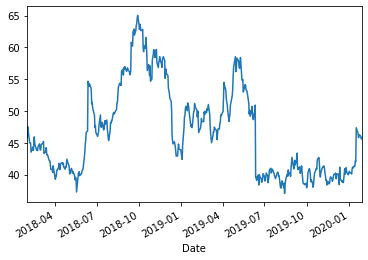

In [39]:
from matplotlib import pyplot
play.plot()
pyplot.show()

ADF Statistic: -2.349411
p-value: 0.156527
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


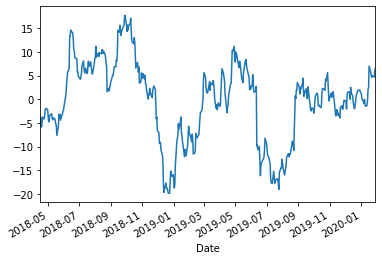

In [40]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# Make stationary
X = play.values
X = X.astype('float32')
# difference data
weeks_in_year = 52
stationary = difference(X, weeks_in_year)
stationary.index = play.index[weeks_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
#stationary.to_csv('data/stationary.csv')
# plot
stationary.plot()
pyplot.show()

In [0]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

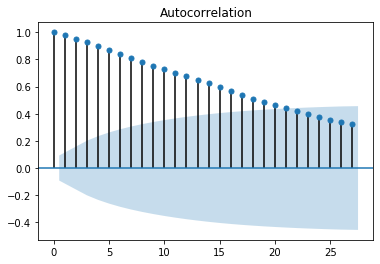

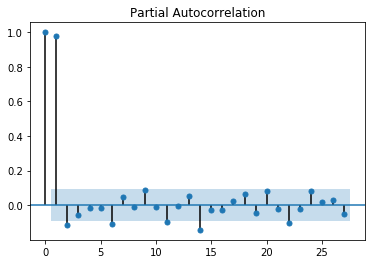

In [42]:
# USING STATIONARY TIME SERIES LOOK FOR ACF & PACF
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(stationary, ax=pyplot.gca())
pyplot.show()

plot_pacf(stationary, ax=pyplot.gca())
pyplot.show()


Predict

In [43]:
# CREATE TRAIN-TEST DATA
X = play.values
X = X.astype('float32')
print(X.size)
train = X[:466]
test = X[467:]
history = [x for x in train]

503


In [0]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

In [0]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [0]:
# CODE RUNS LONG FOR EVALUATION - approximately 
import warnings
import numpy
 
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		weeks_in_year = 52
		diff = difference(history, weeks_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, weeks_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
#evaluate_models(play.values, p_values, d_values, q_values)
# Best: ARIMA(1, 0, 0) RMSE=1.779

>Predicted=45.467, Expected= 40
>Predicted=40.850, Expected= 40
>Predicted=40.449, Expected= 40
>Predicted=39.694, Expected= 38
>Predicted=38.855, Expected= 41
>Predicted=41.145, Expected= 39
>Predicted=40.132, Expected= 39
>Predicted=39.057, Expected= 39
>Predicted=44.260, Expected= 39
>Predicted=38.344, Expected= 39
>Predicted=38.505, Expected= 39
>Predicted=39.315, Expected= 41
>Predicted=41.161, Expected= 40
>Predicted=40.004, Expected= 41
>Predicted=40.784, Expected= 40
>Predicted=40.728, Expected= 40
>Predicted=34.533, Expected= 40
>Predicted=39.983, Expected= 41
>Predicted=40.259, Expected= 40
>Predicted=38.907, Expected= 40
>Predicted=42.914, Expected= 40
>Predicted=38.218, Expected= 41
>Predicted=40.649, Expected= 41
>Predicted=40.876, Expected= 41
>Predicted=41.163, Expected= 41
>Predicted=41.239, Expected= 41
>Predicted=41.078, Expected= 42
>Predicted=44.281, Expected= 42
>Predicted=41.122, Expected= 47
>Predicted=48.200, Expected= 46
>Predicted=45.718, Expected= 46
>Predict

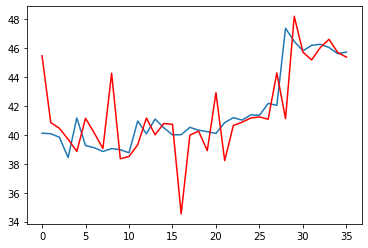

In [53]:
predictions = list()
for i in range(len(test)):
	# difference data
	weeks_in_year = 52
	diff = difference(history, weeks_in_year)
	# predict
	model = ARIMA(diff, order=(1,0,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, weeks_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
 
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

               0
count  36.000000
mean    0.001950
std     2.214015
min    -5.357361
25%    -0.832928
50%     0.101250
75%     0.721844
max     6.248287
RMSE: 2.183


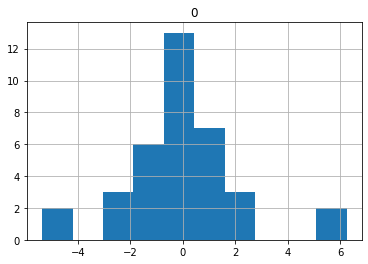

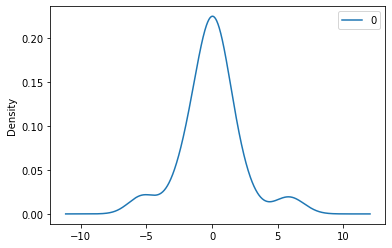

In [54]:
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# plot
residuals.hist(ax=pyplot.gca())
pyplot.show()

residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()


Forecast

In [58]:
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=5)[0]

wk = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, 52)
	print('Week %d: %f' % (wk, inverted))
	history.append(inverted)
	wk += 1

Week 1: 45.990899
Week 2: 46.205453
Week 3: 45.903572
Week 4: 46.135158
Week 5: 45.980117
